max error = 0.00035787357266858777


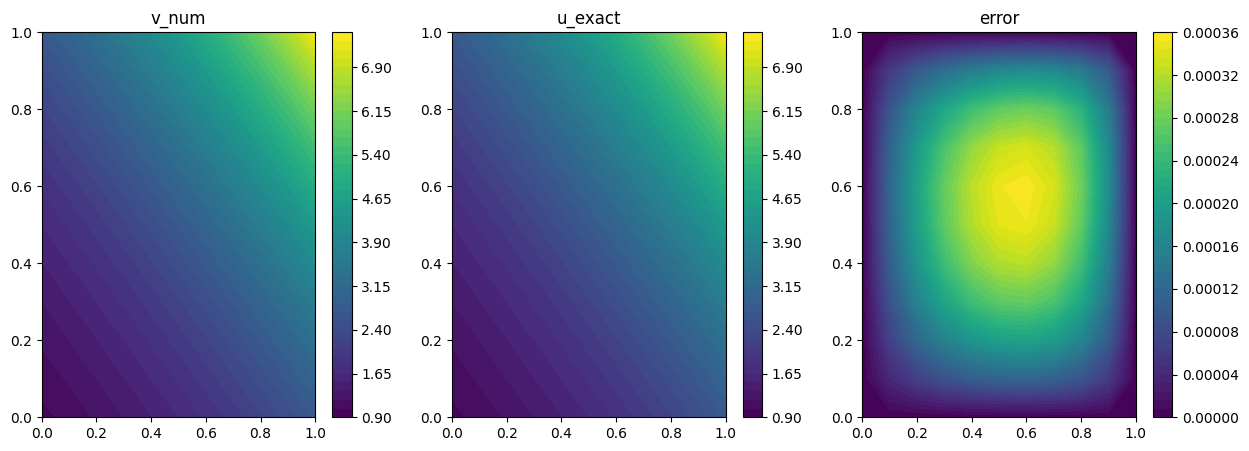

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры
Lx, Ly = 1.0, 1.0
T = 1.0
Nx, Ny = 10, 10
hx, hy = Lx/Nx, Ly/Ny
tau = 1e-4
Nt = int(T/tau)

x = np.linspace(0, Lx, Nx+1)
y = np.linspace(0, Ly, Ny+1)
X, Y = np.meshgrid(x, y, indexing='ij')


def exact(x,y,t):
    return t * np.exp(x+y)

def phi(x,y,t):
    return np.exp(x+y)*(1-2*t)


def solve(a,b,c,d):
    n = len(d)
    cp = np.zeros(n-1); dp = np.zeros(n)
    cp[0] = c[0]/b[0]; dp[0] = d[0]/b[0]
    for i in range(1,n-1):
        denom = b[i] - a[i-1]*cp[i-1]
        cp[i] = c[i]/denom
        dp[i] = (d[i] - a[i-1]*dp[i-1])/denom
    dp[n-1] = (d[n-1] - a[n-2]*dp[n-2])/(b[n-1]-a[n-2]*cp[n-2])
    x = np.zeros(n); x[-1] = dp[-1]
    for i in range(n-2,-1,-1):
        x[i] = dp[i] - cp[i]*x[i+1]
    return x


v = np.zeros((Nx+1,Ny+1))

# границы в t=0
v[0,:]   = exact(x[0],   y, 0)
v[-1,:]  = exact(x[-1],  y, 0)
v[:,0]   = exact(x,      y[0], 0)
v[:,-1]  = exact(x,      y[-1],0)


rx = tau/(2*hx*hx)
ry = tau/(2*hy*hy)

for n in range(Nt):
    t_n = n*tau
    t_np1 = (n+1)*tau

    #граничные mû для первого полушага
    mu_n   = exact(X, Y, t_n)
    mu_np1 = exact(X, Y, t_np1)

    # A2(mu_np1 - mu_n) по y-направлению
    A2mu = np.zeros_like(mu_n)
    A2mu[:,1:-1] = (mu_np1[:,2:] - 2*mu_np1[:,1:-1] + mu_np1[:,:-2])/(hy**2) \
                  - (mu_n[:,2:] - 2*mu_n[:,1:-1] + mu_n[:,:-2])/(hy**2)
    mu_hat = 0.5*(mu_np1 + mu_n) - (tau/4)*A2mu

    # --- ПОЛУШАГ 1
    v_half = np.zeros_like(v)

    for j in range(1,Ny):
        a = -rx*np.ones(Nx-1)
        b =  1 + 2*rx
        c = -rx*np.ones(Nx-1)
        d = np.zeros(Nx-1)
        for i in range(1,Nx):
            d[i-1] = ry*(v[i, j+1] - 2*v[i,j] + v[i,j-1]) \
                     + v[i,j] + (tau/2)*phi(x[i],y[j],t_n)

        # граничные в узлах
        d[0]   += rx * mu_hat[0,j]
        d[-1]  += rx * mu_hat[-1,j]
        v_half[1:Nx,j] = solve(a, b*np.ones_like(a), c, d)
    # граничные
    v_half[0,:]  = mu_hat[0,:]
    v_half[-1,:] = mu_hat[-1,:]
    v_half[:,0]  = mu_hat[:,0]
    v_half[:,-1] = mu_hat[:,-1]

    # --- ПОЛУШАГ 2
    v_new = np.zeros_like(v)
    for i in range(1,Nx):
        a = -ry*np.ones(Ny-1)
        b =  1 + 2*ry
        c = -ry*np.ones(Ny-1)
        d = np.zeros(Ny-1)
        for j in range(1,Ny):
            d[j-1] = rx*(v_half[i+1,j] - 2*v_half[i,j] + v_half[i-1,j]) \
                     + v_half[i,j] + (tau/2)*phi(x[i],y[j],t_n)
        # граничные j=0,Ny
        d[0]    += ry * mu_np1[i,0]
        d[-1]   += ry * mu_np1[i,-1]
        v_new[i,1:Ny] = solve(a, b*np.ones_like(a), c, d)
    # граничные
    v_new[0,:]  = mu_np1[0,:]
    v_new[-1,:] = mu_np1[-1,:]
    v_new[:,0]  = mu_np1[:,0]
    v_new[:,-1] = mu_np1[:,-1]

    v = v_new


u_ex = exact(X,Y,T)
err = np.abs(v - u_ex)
print("max error =", np.max(err))


fig, axs = plt.subplots(1,3,figsize=(15,5))
for ax, U, title in zip(axs, (v, u_ex, err),
                        ("v_num","u_exact","error")):
    cf = ax.contourf(X,Y,U, 50)
    ax.set_title(title)
    fig.colorbar(cf,ax=ax)
plt.show()
